In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

import glob
import pprint
import math


# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']


# uses custom metis style sheet for notebooks
from IPython.core.display import HTML
HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")

Populating the interactive namespace from numpy and matplotlib


/Users/greg/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
testdf = pd.DataFrame([
    [1, 2, 3],
    [4, 5, 6]
])

In [5]:
test1 = [0, 1, 2]
test2 = [4, 5, 6]
test = [*test1, *test2]
test

[0, 1, 2, 4, 5, 6]

In [4]:
testdf.to_csv('mytest.csv', sep='\t')

In [31]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [15]:
# 6 unique words: cold, greg, hot, rainy, sunny, test
doc_array = [
    'cold',
    'hot',
    'this is test and is sunny',
    'greg is a test rainy'
]

In [13]:
new_text = [
    'greg is cold'
]

In [101]:
combined_docs = doc_array + new_text

In [14]:
vectorizer = CountVectorizer(stop_words='english')
doc_words = vectorizer.fit_transform(doc_array)
print('count vectorizer shape:', doc_words.shape)
df = pd.DataFrame(doc_words.toarray(), columns=vectorizer.get_feature_names())
df

count vectorizer shape: (4, 6)


,cold,greg,hot,rainy,sunny,test
0,1,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,1,1
3,0,1,0,1,0,1


In [24]:

reducer_model = TruncatedSVD(3)
doc_topic = reducer_model.fit_transform(doc_words)
explained_ratio = reducer_model.explained_variance_ratio_
print(explained_ratio)


[0.40094916 0.28326137 0.15789474]


,cold,greg,hot,rainy,sunny,test
comp1,-0.0,0.447,-0.0,0.447,0.276,0.724
comp2,-0.0,-0.447,0.0,-0.447,0.724,0.276
comp3,1.0,0.000,0.0,0.000,0.000,0.000


In [26]:
doc_topic

array([[-0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.11176968e-16,  6.52572721e-17,  0.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.61803399e+00, -6.18033989e-01,  0.00000000e+00]])

In [25]:
topic_word_df = pd.DataFrame(
    reducer_model.components_.round(3),
    index=['comp1', 'comp2', 'comp3'],
    columns= vectorizer.get_feature_names()
)
topic_word_df

,cold,greg,hot,rainy,sunny,test
comp1,-0.0,0.447,-0.0,0.447,0.276,0.724
comp2,-0.0,-0.447,0.0,-0.447,0.724,0.276
comp3,1.0,0.000,0.0,0.000,0.000,0.000


In [32]:
Vt = pd.DataFrame(
    doc_topic.round(5),
    index=doc_array,
    columns=['comp1', 'comp1', 'comp3']
)
Vt

,comp1,comp1,comp3
cold,-0.00000,0.00000,1.0
hot,-0.00000,0.00000,0.0
this is test and is sunny,1.00000,1.00000,0.0
greg is a test rainy,1.61803,-0.61803,0.0


In [33]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters) 
X_trans = km.fit_transform(doc_topic)

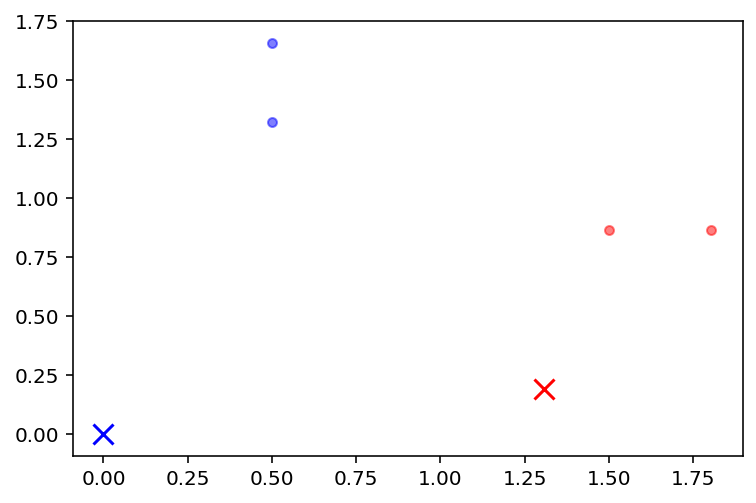

In [37]:
display_cluster(X_trans,km,num_clusters)

In [40]:
new_doc_words = vectorizer.transform(new_text)


In [43]:
new_doc_words.toarray()

array([[1, 1, 0, 0, 0, 0]])

In [44]:
new_df = pd.DataFrame(
    new_doc_words.toarray(),
    index=new_text,
    columns=vectorizer.get_feature_names()
)
new_df

,cold,greg,hot,rainy,sunny,test
greg is cold,1,1,0,0,0,0


In [70]:
new_doc_words_reduced = reducer_model.transform(new_doc_words)

In [71]:
new_doc_words_reduced

array([[ 0.4472136, -0.4472136,  1.       ]])

In [72]:
X_trans

array([[0.5       , 1.6583124 ],
       [0.5       , 1.32287566],
       [1.5       , 0.8660254 ],
       [1.80277564, 0.8660254 ]])

In [73]:
new_doc_km = km.transform(new_doc_words_reduced)

In [74]:
new_doc_km

array([[0.80622577, 1.46628783]])

In [75]:
X = np.append(X_trans, new_doc_km).reshape(5, 2)

In [77]:
print(new_doc_km)
display_cluster(X, km, 2)

[[0.80622577 1.46628783]]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 4

In [82]:
km.labels_

array([0, 0, 1, 1], dtype=int32)

In [81]:
km.predict(new_doc_words_reduced)

array([0], dtype=int32)

In [103]:
last_col = cosine_similarity(X)[0:-1, -1]
print(last_col)
zipped = list(zip(range(len(last_col)), last_col))
zipped
similar_books = sorted(zipped, key=lambda x: x[1], reverse=True)
book_ids = np.array(similar_books)[:, 0].astype(int)

results = []
for book_id in list(book_ids):
    results.append(doc_array[book_id])
results

[0.9780562  0.9900261  0.85539877 0.81373754]


['hot', 'cold', 'this is test and is sunny', 'greg is a test rainy']

In [102]:
pd.DataFrame(
    cosine_similarity(X),
    index = combined_docs,
    columns = combined_docs,
)

,cold,hot,this is test and is sunny,greg is a test rainy,greg is cold
cold,1.000000,0.997653,0.728714,0.674786,0.978056
hot,0.997653,1.000000,0.773893,0.723735,0.990026
this is test and is sunny,0.728714,0.773893,1.000000,0.997131,0.855399
greg is a test rainy,0.674786,0.723735,0.997131,1.000000,0.813738
greg is cold,0.978056,0.990026,0.855399,0.813738,1.000000


In [108]:
test = np.array(['a', 'b', 'c'])
bools = np.array([False, True, False])
nums = np.array([0, 1, 0])

In [107]:
test[bools]

array(['b'], dtype='<U1')

In [109]:
test[nums]

array(['a', 'b', 'a'], dtype='<U1')

In [113]:
model_transformed_docs = np.array([
    [1, 2, 3, 4, 5, 6],
    [5, 6, 7, 8, 9, 10],
    [9, 10, 11, 12, 13, 14],
    [13, 14, 15, 16, 17, 18]

])

In [114]:
model_transformed_docs[[False, True, True, False], :]

array([[ 5,  6,  7,  8,  9, 10],
       [ 9, 10, 11, 12, 13, 14]])

In [118]:
arr = np.array([
    [0, 1, 2],
    [3, 4, 5]
])
print(arr.mean(axis=0))
print(arr.mean(axis=1))
print(arr.shape)

[1.5 2.5 3.5]
[1. 4.]
(2, 3)


In [117]:
sum(arr, axis=1)

array([ 3, 12])

In [134]:
numpy.random.rand(3,) * 255

array([226.94651508,  19.52558802, 123.86319644])

In [6]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import numpy as np

docs = np.array([
    'a',
    'b',
    'c'
])

something = np.array([
    # this should be by itself
    [1, 2],
    
    # these two should be closer
    [4, 5],
    [6, 7]
])

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=2))
])

pipeline.fit_transform(something)

pipeline.predict(something)

pipeline.predict(np.array([[7, 7]]))

pipeline.named_steps['kmeans'].labels_

In [12]:
something = np.array([
    [1, 2],
    [4, 5],
    [6, 7]
])

In [11]:
pipeline = Pipeline([
    ('kmeans', KMeans())
])


In [13]:
pipeline.fit_transform(something)

array([[0.        , 5.65685425],
       [4.24264069, 1.41421356],
       [7.07106781, 1.41421356]])

In [14]:
pipeline.predict(something)

array([0, 1, 1], dtype=int32)

In [16]:
pipeline.predict(np.array([[7, 7]]))

array([1], dtype=int32)

In [21]:
pipeline.named_steps['kmeans'].labels_

array([0, 1, 1], dtype=int32)

In [22]:
pipeline.named_steps['kmeans']

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [24]:
pipeline.set_params(kmeans__n_clusters=3)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=3, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [26]:
pipeline.fit_transform(something)

array([[4.24264069, 0.        , 7.07106781],
       [0.        , 4.24264069, 2.82842712],
       [2.82842712, 7.07106781, 0.        ]])

In [27]:
pipeline.predict(something)

array([1, 0, 2], dtype=int32)

In [28]:
str(0.25)

'0.25'

In [40]:

import hashlib
intermediary = ''.join(['hello ', 'world'])
words = intermediary.encode()
hash_object = hashlib.sha1(words)
hex_dig = hash_object.hexdigest()
print(hex_dig)

2aae6c35c94fcfb415dbe95f408b9ce91ee846ed


In [41]:
[][0]

IndexError: list index out of range